In [27]:
from solarmask.data import *
from solarmask.active_region import *
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('image', cmap='gray')

# 1 Project Summary
***

This library is designed to take an active region image from the hard drive and turn it into a set of four different datasets. This jupyter notebook is only about showing what the library does, so don't worry too much about the code. Refer to getting_started.ipynb and AddingFieldParameters.ipynb when you want to start developing with it.

### Raw Data
The raw data is stored as "fits" files on the hard drive. There is a magnetogram (a 3 dimensional vector field expressing the magnetic flux vector at each pixel) and a continuum (a single field expressing the intensity in light of each pixel). 

The four raw datasets of a single active region chosen at the same time point are shown visually below:

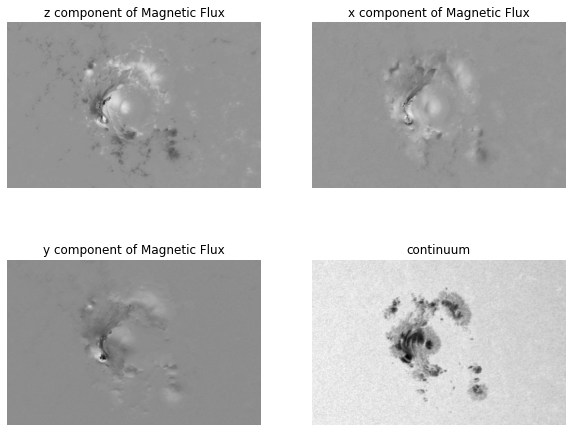

In [28]:
hnum = 7115
root = "../example_data/raw"

dates = get_dates(hnum, root)
data = get_data(hnum, dates[1], root)

fig, axs = plt.subplots(2, 2)

axs[0][0].imshow(data["Bz"])
axs[0][0].axis(False)
axs[0][0].set_title("z component of Magnetic Flux")

axs[0][1].imshow(data["Bx"])
axs[0][1].axis(False)
axs[0][1].set_title("x component of Magnetic Flux")

axs[1][0].imshow(data["By"])
axs[1][0].axis(False)
axs[1][0].set_title("y component of Magnetic Flux")

axs[1][1].imshow(data["cont"])
axs[1][1].axis(False)
axs[1][1].set_title("continuum")

fig.set_figwidth(10)
fig.set_figheight(8)
plt.savefig("./outputs/allraw.png")
plt.show()

### Active Region Class
My ActiveRegionClass does two things. The first thing it does is segment the active region based on four physical subregions (not necessarily disjoint): neutral line, umbra, penumbra (and the negation of all of these as the background). Rather than explain them, I will show them first in the plots below for the same raw data as above, then explain what each means:

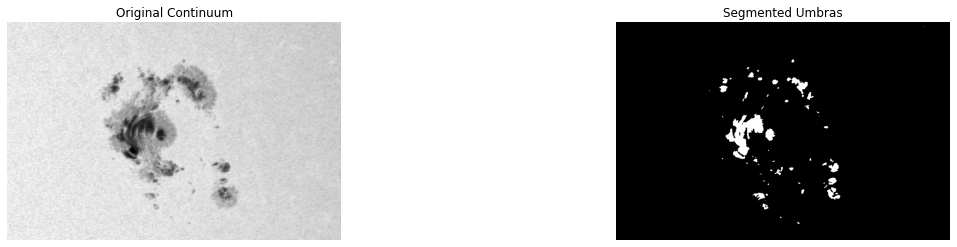

In [29]:
ar = ActiveRegion(hnum, dates[1], root)

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.imshow(ar.cont)
ax1.axis(False)
ax1.set_title("Original Continuum")

ax2.imshow(ar.umbra_mask)
ax2.axis(False)
ax2.set_title("Segmented Umbras")

fig.set_figwidth(20)
fig.set_figwidth(20)

plt.savefig("./outputs/umbras.png")
plt.show()

The umbra is the distinct black hole in the continuum. I extract the umbra using various methods from mathematical morphology and topology. Note that it is the center black hole, while the penumbra surrounds it:

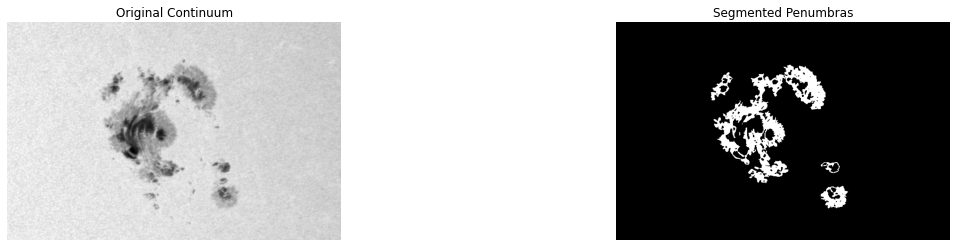

In [30]:
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.imshow(ar.cont)
ax1.axis(False)
ax1.set_title("Original Continuum")

ax2.imshow(ar.penumbra_mask)
ax2.axis(False)
ax2.set_title("Segmented Penumbras")

fig.set_figwidth(20)
fig.set_figwidth(20)

plt.savefig("./outputs/penumbras.png")
plt.show()

As you can see above, the umbra and penumbra are tied closely to one another. The umbra is sometimes accompanied by a penumbra, but a penumbra cannot exist alone. An active region can have no umbra / penumbra which would result in a completely blank mask above. The umbra and penumbra are stored as binary arrays where a true pixel means it is an element of the umbra / penumbra which itself is a subset of the active region.

The neutral line (TODO - get a better example when swami is back online) is an area determined by the magnetic field. The neutral line is an area of high magnetic field gradient with a (theoretically) zero magnetic field. It is the intersection of a large positive and negative region of the active region.

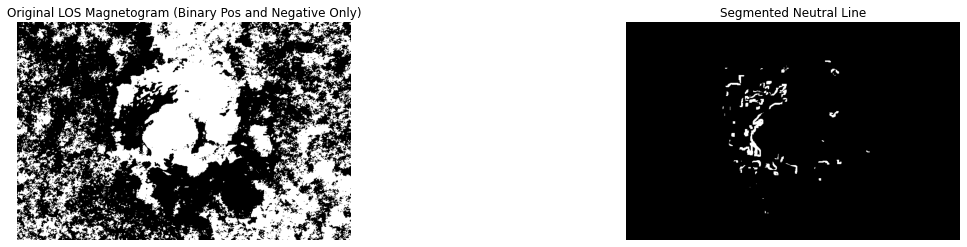

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2)

Bz = ar.Bz.copy()
Bz[Bz > 0] = 1
Bz[Bz < 0] = -1
ax1.imshow(Bz)
ax1.axis(False)
ax1.set_title("Original LOS Magnetogram (Binary Pos and Negative Only)")

ax2.imshow(ar.nl_mask)
ax2.axis(False)
ax2.set_title("Segmented Neutral Line")

fig.set_figwidth(20)
fig.set_figwidth(20)

plt.savefig("./outputs/nl.png")
plt.show()

The background is just the negation of all of these subsets so we don't lose any information

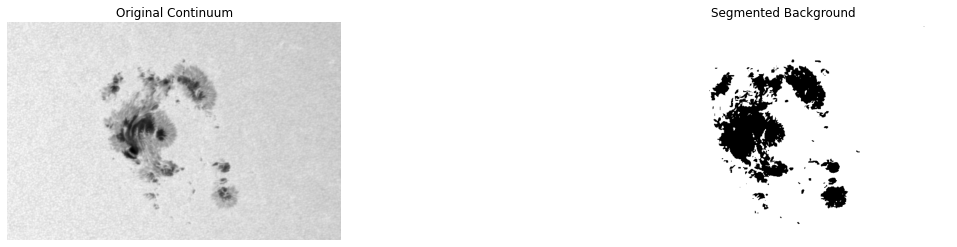

In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.imshow(ar.cont)
ax1.axis(False)
ax1.set_title("Original Continuum")

ax2.imshow(ar.background_mask)
ax2.axis(False)
ax2.set_title("Segmented Background")

fig.set_figwidth(20)
fig.set_figwidth(20)

plt.savefig("./outputs/background.png")
plt.show()

### Segmented vs Baseline Dataset

In the above images, the black represents a "subset" of the active region. There are 58 physical scalars that I have written methods for (I've designe Active Region so that you can add more if you want) such as total magnetic flux or mean of the continuum intensity. These 58 features aren't too important yet. ActiveRegion computes these physical features for the entire active region (baseline) and for each individual subset (segmented). 

Baseline is a 58 dimensional feature vector with unique labels:

In [33]:
print(ar.baseline_dataset)

{'Bz_tot': 48436571.73000002, 'Bz_totabs': 912665.0699999997, 'itot': 1158731875.8816144, 'itotabs': 513884.65279076196, 'itot_polarity': 69741420.32692963, 'ihtot': 260424630525.3697, 'ihtotabs': 3658852029.034691, 'hctot': 346536044344.56824, 'hctotabs': 152841919638.9422, 'totrho': 21887487.611776374, 'Bz_mean': 2.9610447920992518, 'Bz_std': 353.91205722553934, 'Bz_skew': 0.8624891360407722, 'Bz_kurt': 15.705697123960512, 'Bh_mean': 181.74443637163253, 'Bh_std': 301.11945941453774, 'Bh_skew': 4.275037651713445, 'Bh_kurt': 27.07156202696789, 'gamma_mean': -0.1003125604687583, 'gamma_std': 0.6785771694077445, 'gamma_skew': 0.20137146281062596, 'gamma_kurt': -1.0749836556997958, 'grad_B_mean': 49.819821037258365, 'grad_B_std': 72.48970397795553, 'grad_B_skew': 10.687045428877381, 'grad_B_kurt': 214.83928901171123, 'grad_Bz_mean': 51.636673855447874, 'grad_Bz_std': 81.89618924956946, 'grad_Bz_skew': 9.117129105709143, 'grad_Bz_kurt': 162.31031800893274, 'grad_Bh_mean': 37.43074113475015

And segmented is the same physical features, but for just the subsets (and then stacked on top of each other). So segmented is a vector:

\[features(neutral line), features(umbra), features(penumbra), features(background)\]

This means it is a 4 * 58 dimensional vector (232):

In [34]:
print(ar.segmented_dataset)

{'nl_Bz_tot': 1730154.0, 'nl_Bz_totabs': 74285.20000000001, 'nl_itot': 72911186.77918473, 'nl_itotabs': 5502452.308782724, 'nl_itot_polarity': 8855326.523065047, 'nl_ihtot': 77831129621.29727, 'nl_ihtotabs': 246844235.33597994, 'nl_hctot': 57063866401.77635, 'nl_hctotabs': 12216768812.036888, 'nl_totrho': 6131235.380608724, 'nl_Bz_mean': -18.233971526755035, 'nl_Bz_std': 723.3068414530032, 'nl_Bz_skew': -0.5455602300328546, 'nl_Bz_kurt': 5.615103176236618, 'nl_Bh_mean': 1132.8273410495333, 'nl_Bh_std': 851.3247532920949, 'nl_Bh_skew': 1.189955019812326, 'nl_Bh_kurt': 1.2650226810732885, 'nl_gamma_mean': 0.0018664835082713447, 'nl_gamma_std': 0.5023637771433762, 'nl_gamma_skew': 0.09755952858633657, 'nl_gamma_kurt': 0.6208295788868163, 'nl_grad_B_mean': 250.90027949302583, 'nl_grad_B_std': 349.3953113840282, 'nl_grad_B_skew': 3.0308016114527065, 'nl_grad_B_kurt': 10.88481453737684, 'nl_grad_Bz_mean': 344.88730013572416, 'nl_grad_Bz_std': 383.2043553122473, 'nl_grad_Bz_skew': 2.604300650